In [1]:
from typing import Sequence

import jax
import jax.numpy as jnp
import numpy as np
import tensorflow_datasets as tfds
from flax import linen as nn
from flax.training import train_state
import optax
import orbax.checkpoint as ocp
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.collections import LineCollection


In [2]:
# Load MNIST from TensorFlow Datasets
data_dir = '/tmp/tfds' # data_dir = './data/tfds'
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)

I0000 00:00:1766269760.411342     462 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2240 MB memory:  -> device: 0, name: Quadro T2000, pci bus id: 0000:01:00.0, compute capability: 7.5


In [3]:
def normalise(x, x_max=255.0):
    return x / x_max

def convert_to_jax(data_np, data_type):
    if data_type == "image":
        data_jax = normalise(jnp.array(data_np, dtype=jnp.float32))
    elif data_type == "label":
        data_jax = jnp.array(data_np)
    else:
        raise ValueError("not image or label")
    return data_jax

def flatten_image_for_mlp(data_jax):
    """Produces one greyscale vector per sample"""
    n_batch, n_pixels_vertical, n_pixels_horizontal, n_channels = data_jax.shape
    data_flattened = data_jax.reshape(n_batch, -1)
    return data_flattened

def prepare_data(data_dict: dict, subsample_size: int=0):
    data_jax = {}
    for data_type, data_tf in data_dict.items():
        data_numpy = data_tf.numpy()
        data = convert_to_jax(data_numpy, data_type)
        if data_type == "image":
            data = flatten_image_for_mlp(data)
        if subsample_size > 0:
            data = data[:subsample_size]
        data_jax[data_type] = data

    return data_jax

In [4]:
class MLP(nn.Module):
    layer_sizes: Sequence[int]

    @nn.compact
    def __call__(self, activations):
        for layer_number, layer_size in enumerate(self.layer_sizes):
            activations = nn.Dense(
                layer_size,
                kernel_init=nn.initializers.normal(0.1),
                bias_init=nn.initializers.normal(0.1)
            )(activations)

            if layer_number != (len(self.layer_sizes) - 1):
                activations = nn.relu(activations)

        return activations

In [5]:
class LowRankDense(nn.Module):
    """Low-rank dense layer implemented with two factors and einsum.

    Parameters are U in R^{in_features x rank} and V in R^{rank x features}.
    The forward pass computes y = (x @ U) @ V + b using einsum.
    """
    features: int
    rank: int
    use_bias: bool = True

    @nn.compact
    def __call__(self, inputs):
        # inputs: [batch, in_features]
        in_features = inputs.shape[-1]

        U = self.param(
            "U",
            nn.initializers.normal(0.1),
            (in_features, self.rank),
        )
        V = self.param(
            "V",
            nn.initializers.normal(0.1),
            (self.rank, self.features),
        )

        hidden = jnp.einsum("bi,ir->br", inputs, U)
        y = jnp.einsum("br,rf->bf", hidden, V)

        if self.use_bias:
            bias = self.param(
                "bias",
                nn.initializers.normal(0.1),
                (self.features,),
            )
            y = y + bias

        return y


class LowRankMLP(nn.Module):
    """
    Every layer uses the same low-rank dimension rank (="rank")
    """
    layer_sizes: Sequence[int]
    rank: int

    @nn.compact
    def __call__(self, activations):
        for layer_number, layer_size in enumerate(self.layer_sizes):
            activations = LowRankDense(
                features=layer_size,
                rank=self.rank,
                use_bias=True,
            )(activations)

            if layer_number != (len(self.layer_sizes) - 1):
                activations = nn.relu(activations)

        return activations

In [6]:
def initialise_network_params(model, input_layer_size, key):
    """Initialize all layers for a fully-connected neural network"""
    input_shape_dummy = jnp.ones((1, input_layer_size))
    params = model.init(key, input_shape_dummy)["params"]
    return params

In [7]:
def create_training_state(layer_sizes, optimizer, key, use_lowrank: bool = False, rank: int | None = None):
    input_layer_size = layer_sizes[0]
    network_layer_sizes = layer_sizes[1:]

    if use_lowrank:
        if rank is None:
            raise ValueError("rank must be provided when use_lowrank=True")
        model = LowRankMLP(layer_sizes=network_layer_sizes, rank=rank)
    else:
        model = MLP(layer_sizes=network_layer_sizes)

    apply_fn = model.apply
    params = initialise_network_params(model, input_layer_size, key)
    training_state = train_state.TrainState.create(
        apply_fn=apply_fn,
        params=params,
        tx=optimizer,
    )
    return training_state

In [8]:
def cross_entropy_loss_single_label(logits, label):
    targets = jnp.full_like(logits, label)
    return optax.sigmoid_binary_cross_entropy(logits, targets).mean()

def generator_loss_nonsaturating(logits_real_given_fake):
    """Objective: maximise p(predicted real | fake)"""
    return + cross_entropy_loss_single_label(logits=logits_real_given_fake, label=1)

def generator_loss_saturating(logits_real_given_fake):
    """Objective: minimise p(predicted fake | fake)"""
    return - cross_entropy_loss_single_label(logits=logits_real_given_fake, label=0)

def discriminator_loss(logits_real_given_real, logits_real_given_fake):
    loss_given_real = cross_entropy_loss_single_label(logits=logits_real_given_real, label=1)
    loss_given_fake = cross_entropy_loss_single_label(logits=logits_real_given_fake, label=0)
    return (loss_given_real + loss_given_fake) / 2

In [9]:
def calculate_generator_loss(generator_params, discriminator_params, generator_apply_fn, discriminator_apply_fn, z_vector, loss_type="nonsaturating"):
    fake_images = generator_apply_fn({"params": generator_params}, z_vector)
    logits_real_given_fake = discriminator_apply_fn({"params": discriminator_params}, fake_images)
    if loss_type == "nonsaturating":
        return generator_loss_nonsaturating(logits_real_given_fake)
    elif loss_type == "saturating":
        return generator_loss_saturating(logits_real_given_fake)
    else:
        raise ValueError(f"incorrect loss type specified: {loss_type}")


def calculate_discriminator_loss(discriminator_params, generator_params, generator_apply_fn, discriminator_apply_fn, z_vector, real_images):
    fake_images = generator_apply_fn({"params": generator_params}, z_vector)
    logits_real_given_fake = discriminator_apply_fn({"params": discriminator_params}, fake_images)
    logits_real_given_real = discriminator_apply_fn({"params": discriminator_params}, real_images)
    return discriminator_loss(logits_real_given_real, logits_real_given_fake)

In [10]:
@jax.jit
def take_generator_step_nonsaturating(generator, discriminator, z_vector):
    grads_by_params_fn = jax.grad(calculate_generator_loss)
    grads_by_params = grads_by_params_fn(
        generator.params,
        discriminator.params,
        generator.apply_fn,
        discriminator.apply_fn,
        z_vector,
        "nonsaturating",
    )
    return generator.apply_gradients(grads=grads_by_params)


@jax.jit
def take_generator_step_saturating(generator, discriminator, z_vector):
    grads_by_params_fn = jax.grad(calculate_generator_loss)
    grads_by_params = grads_by_params_fn(
        generator.params,
        discriminator.params,
        generator.apply_fn,
        discriminator.apply_fn,
        z_vector,
        "saturating",
    )
    return generator.apply_gradients(grads=grads_by_params)


@jax.jit
def take_discriminator_step(generator, discriminator, z_vector, real_images):
    grads_by_params_fn = jax.grad(calculate_discriminator_loss)
    grads_by_params = grads_by_params_fn(
        discriminator.params,
        generator.params,
        generator.apply_fn,
        discriminator.apply_fn,
        z_vector,
        real_images,
    )
    return discriminator.apply_gradients(grads=grads_by_params)

In [11]:
def subsample_images_for_batch(key, images_full_sample, batch_size):
    image_ids = jax.random.randint(key, (batch_size,), 0, images_full_sample.shape[0])
    return images_full_sample[image_ids]

In [12]:
def run_training_gan(
    train_data,
    n_steps,
    generator_training_state,
    discriminator_training_state,
    key,
    steps_per_save,
    checkpoint_manager,
    batch_size: int,
    latent_dim: int,
    loss_type: str = "nonsaturating",
):
    """Train a GAN using random mini-batches of real images.

    Shapes:
      - train_data["image"]: (N, n_pixels)
      - real_images_batch:   (batch_size, n_pixels)
      - z_vectors:           (batch_size, latent_dim)
    """
    real_images = train_data["image"]

    if loss_type == "nonsaturating":
        take_generator_step = take_generator_step_nonsaturating
    elif loss_type == "saturating":
        take_generator_step = take_generator_step_saturating
    else:
        raise ValueError(f"Unknown loss_type: {loss_type}")

    for step in range(1, n_steps + 1):
        key, key_z_generation, key_real_subsample = jax.random.split(key, 3)

        # Random mini-batch of real images
        real_images_batch = subsample_images_for_batch(
            key_real_subsample,
            real_images,
            batch_size,
        )

        # Latent vectors for generator
        z_vectors = jax.random.normal(
            key_z_generation,
            (batch_size, latent_dim),
        )

        # Update discriminator then generator
        discriminator_training_state = take_discriminator_step(
            generator_training_state,
            discriminator_training_state,
            z_vectors,
            real_images_batch,
        )
        generator_training_state = take_generator_step(
            generator_training_state,
            discriminator_training_state,
            z_vectors,
        )

        # Monitor losses
        generator_loss_value = calculate_generator_loss(
            generator_training_state.params,
            discriminator_training_state.params,
            generator_training_state.apply_fn,
            discriminator_training_state.apply_fn,
            z_vectors,
            loss_type=loss_type,
        )
        discriminator_loss_value = calculate_discriminator_loss(
            discriminator_training_state.params,
            generator_training_state.params,
            generator_training_state.apply_fn,
            discriminator_training_state.apply_fn,
            z_vectors,
            real_images_batch,
        )
        print(
            f"step {step}: generator_loss={generator_loss_value}, "
            f"discriminator_loss={discriminator_loss_value}"
        )

        if step == 1 or step % steps_per_save == 0:
            checkpoint_manager.save(
                step,
                args=ocp.args.StandardSave(
                    {
                        "generator": generator_training_state,
                        "discriminator": discriminator_training_state,
                    }
                ),
            )

    return generator_training_state, discriminator_training_state, key

In [13]:
def sample_batch(images, labels, n_batches):
    """Drops the last set of samples if they're not the right length"""
    n_samples = len(images)
    assert len(images) == len(labels)
    assert n_samples >= n_batches
    assert n_batches > 0
    n_samples_per_batch = n_samples // n_batches
    start = 0
    end = n_samples_per_batch
    while end <= n_samples: 
        yield (images[start:end], labels[start:end])
        start += n_samples_per_batch
        end += n_samples_per_batch

In [14]:
def setup_gan_training(optimizer, key, latent_dim):
    N_PIXELS = 784
    N_HIDDEN_LAYER = 128
    N_BINARY_CATEGORIES = 1

    # Generator maps from latent space (latent_dim) to image space (N_PIXELS)
    layer_sizes_generator = [latent_dim, N_HIDDEN_LAYER, N_PIXELS]
    layer_sizes_discriminator = [N_PIXELS, N_HIDDEN_LAYER, N_BINARY_CATEGORIES]

    g_key, d_key = jax.random.split(key)
    generator_training_state = create_training_state(layer_sizes_generator, optimizer, g_key)
    discriminator_training_state = create_training_state(layer_sizes_discriminator, optimizer, d_key)
    return generator_training_state, discriminator_training_state, key

In [15]:
def make_experiment_name(optimizer):
    opt_name = optimizer.__class__.__name__
    return f"gan_{opt_name}"


def initialise_checkpoint_manager(experiment_name: str = "gan", max_to_keep=20):
    project_root = Path().resolve()
    base_dir = project_root / "checkpoints"
    checkpoint_dir = base_dir / experiment_name
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    checkpoint_manager = ocp.CheckpointManager(
        directory=str(checkpoint_dir),
        options=ocp.CheckpointManagerOptions(max_to_keep=max_to_keep),
    )
    return checkpoint_manager

In [16]:
def train_gan(
    train_data, 
    optimizer, 
    n_steps=10**3, 
    steps_per_save=100, 
    key=jax.random.key(0),
    batch_size: int = 128,
    latent_dim: int = 64,
    loss_type: str = "nonsaturating",
    ):
    experiment_name = make_experiment_name(optimizer) + f"_{loss_type}"
    checkpoint_manager = initialise_checkpoint_manager(experiment_name)

    generator_training_state, discriminator_training_state, key = setup_gan_training(
        optimizer=optimizer,
        key=key,
        latent_dim=latent_dim,
    )

    generator_training_state, discriminator_training_state, key = run_training_gan(
        train_data=train_data,
        n_steps=n_steps,
        generator_training_state=generator_training_state,
        discriminator_training_state=discriminator_training_state,
        key=key,
        steps_per_save=steps_per_save,
        checkpoint_manager=checkpoint_manager,
        batch_size=batch_size,
        latent_dim=latent_dim,
        loss_type=loss_type,
    )
    return generator_training_state, discriminator_training_state, key

W1220 22:29:23.394317     727 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1220 22:29:23.397267     462 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [17]:
train_data = prepare_data(mnist_data["train"], subsample_size=10**4) 
test_data = prepare_data(mnist_data["test"], subsample_size=10**3) 

In [18]:
def run_experiment_for_loss_type(
    loss_type: str,
    train_data,
    learning_rate: float = 1e-3,
    batch_size: int = 128,
    latent_dim: int = 64,
    n_steps: int = 5_000,
    steps_per_save: int = 250,
    seed: int = 0,
):
    """Train GAN and save checkpoints for a given loss_type.

    This function returns training results; plotting is handled separately.

    loss_type: "nonsaturating" or "saturating".
    """
    print(f"=== Running experiment with loss_type={loss_type} ===")

    # Optimizer and PRNG key
    optimizer = optax.adam(learning_rate)
    key = jax.random.key(seed)

    # Train GAN and save checkpoints
    generator_training_state, discriminator_training_state, key = train_gan(
        train_data=train_data,
        optimizer=optimizer,
        n_steps=n_steps,
        steps_per_save=steps_per_save,
        key=key,
        batch_size=batch_size,
        latent_dim=latent_dim,
        loss_type=loss_type,
    )

    # --- Loss curves over checkpoints for this loss_type ---
    gen_tmpl, disc_tmpl, _ = setup_gan_training(
        optimizer,
        key=jax.random.key(0),
        latent_dim=latent_dim,
    )
    experiment_name = make_experiment_name(optimizer) + f"_{loss_type}"
    ckpt_manager = initialise_checkpoint_manager(experiment_name)
    steps = sorted(ckpt_manager.all_steps())

    g_losses, d_losses = [], []
    real_images = train_data["image"]

    for step in steps:
        restored = ckpt_manager.restore(
            step,
            args=ocp.args.StandardRestore(
                item={"generator": gen_tmpl, "discriminator": disc_tmpl}
            ),
        )
        gen_state = restored["generator"]
        disc_state = restored["discriminator"]

        key = jax.random.key(0)
        key, z_key = jax.random.split(key)
        z_vectors = jax.random.normal(
            z_key,
            (real_images.shape[0], latent_dim),
        )

        g_loss = calculate_generator_loss(
            gen_state.params,
            disc_state.params,
            gen_state.apply_fn,
            disc_state.apply_fn,
            z_vectors,
            loss_type=loss_type,
        )
        d_loss = calculate_discriminator_loss(
            disc_state.params,
            gen_state.params,
            gen_state.apply_fn,
            disc_state.apply_fn,
            z_vectors,
            real_images,
        )

        g_losses.append(float(g_loss))
        d_losses.append(float(d_loss))

    # Collect results (plotting handled separately)
    return {
        "generator_state": generator_training_state,
        "discriminator_state": discriminator_training_state,
        "steps": steps,
        "g_losses": g_losses,
        "d_losses": d_losses,
        "loss_type": loss_type,
        "latent_dim": latent_dim,
    }


In [19]:
def plot_experiment_for_loss_type(results, train_data):
    """Plot sample images and loss dynamics for a single loss_type run.

    Expects the dict returned by `run_experiment_for_loss_type` and the
    corresponding `train_data` used for training.
    """
    loss_type = results["loss_type"]
    generator_training_state = results["generator_state"]
    steps = results["steps"]
    g_losses = results["g_losses"]
    d_losses = results["d_losses"]
    latent_dim = results.get("latent_dim", 64)

    # --- Plot a sample real vs fake image ---
    key = jax.random.key(0)
    key, z_key, real_image_key = jax.random.split(key, 3)
    z_vector = jax.random.normal(z_key, (1, latent_dim))
    real_idx = jax.random.randint(
        real_image_key, shape=(), minval=0, maxval=train_data["image"].shape[0]
    )

    fake_image_flat = generator_training_state.apply_fn(
        {"params": generator_training_state.params},
        z_vector,
    )
    fake_image = fake_image_flat[0].reshape(28, 28)

    real_image_flat = train_data["image"][real_idx]
    real_image = real_image_flat.reshape(28, 28)

    fig, axes = plt.subplots(1, 2, figsize=(4, 2))
    axes[0].imshow(real_image, cmap="gray"); axes[0].set_title(f"Real ({loss_type})"); axes[0].axis("off")
    axes[1].imshow(fake_image, cmap="gray"); axes[1].set_title(f"Fake ({loss_type})"); axes[1].axis("off")
    plt.tight_layout(); plt.show()

    # --- Plot loss curves over checkpoints for this loss_type ---
    plt.figure()
    plt.plot(steps, g_losses, label=f"generator ({loss_type})")
    plt.plot(steps, d_losses, label=f"discriminator ({loss_type})")
    plt.xlabel("training step")
    plt.ylabel("loss")
    plt.title(f"GAN losses ({loss_type})")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Plot training dynamics in (g, d) loss space ---
    g = np.array(g_losses)
    d = np.array(d_losses)

    fig, ax = plt.subplots(figsize=(6, 6))
    points = np.column_stack([g, d])
    segments = np.stack([points[:-1], points[1:]], axis=1)

    t = np.linspace(0.0, 1.0, len(points) - 1)
    colors = cm.coolwarm(t)

    lc = LineCollection(segments, colors=colors, linewidths=1.5)
    ax.add_collection(lc)

    ax.scatter(g, d, c=t.tolist() + [1.0], cmap="coolwarm", s=8, alpha=0.7)
    ax.scatter(g[0], d[0], color="blue", s=50, label="start")
    ax.scatter(g[-1], d[-1], color="red", s=50, label="end")

    ax.set_xlabel("Generator loss")
    ax.set_ylabel("Discriminator loss")
    ax.set_title(f"GAN training dynamics in loss space ({loss_type})")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()


In [20]:
# Convenience: run the full experiment for both loss types

results_by_loss_type = {}
for lt in ["saturating", "nonsaturating"]:
    results_by_loss_type[lt] = run_experiment_for_loss_type(
        loss_type=lt,
        train_data=train_data,
        learning_rate=1e-3,
        batch_size=128,
        latent_dim=64,
        n_steps=5_000,
        steps_per_save=250,
        seed=0,
    )


=== Running experiment with loss_type=saturating ===
step 1: generator_loss=-2.1513190269470215, discriminator_loss=1.2680836915969849
step 2: generator_loss=-2.574666976928711, discriminator_loss=1.4624947309494019
step 3: generator_loss=-2.907804489135742, discriminator_loss=1.6043462753295898
step 4: generator_loss=-3.0833139419555664, discriminator_loss=1.683457851409912
step 5: generator_loss=-3.5509586334228516, discriminator_loss=1.888504147529602
step 6: generator_loss=-4.230525970458984, discriminator_loss=2.2254726886749268
step 7: generator_loss=-4.963939666748047, discriminator_loss=2.570420742034912
step 8: generator_loss=-5.347384452819824, discriminator_loss=2.7596426010131836
step 9: generator_loss=-5.342500686645508, discriminator_loss=2.751652956008911
step 10: generator_loss=-5.551156044006348, discriminator_loss=2.8435750007629395
step 11: generator_loss=-5.927734851837158, discriminator_loss=3.0209474563598633
step 12: generator_loss=-6.205704689025879, discriminat

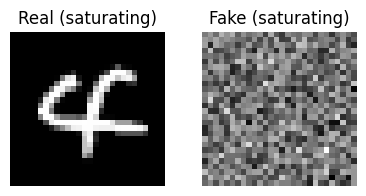

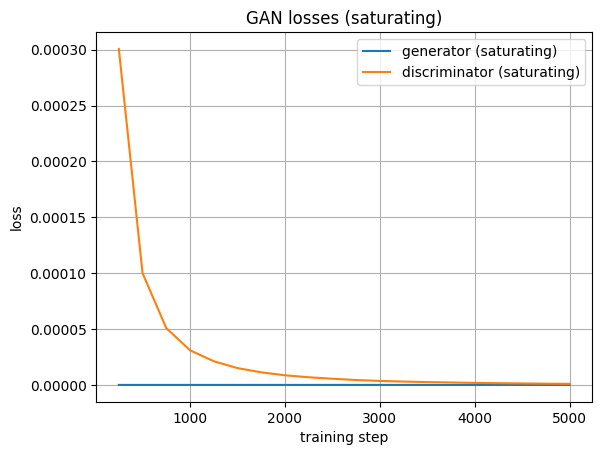

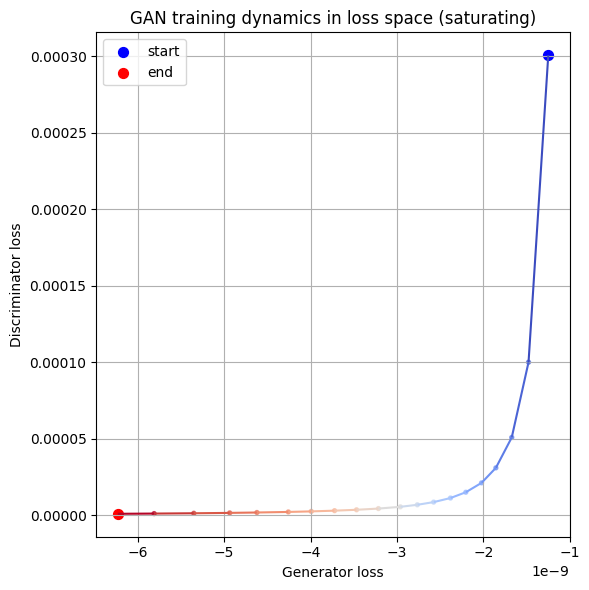

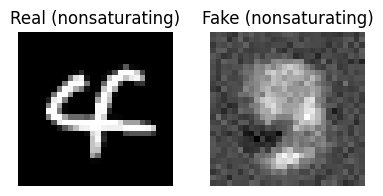

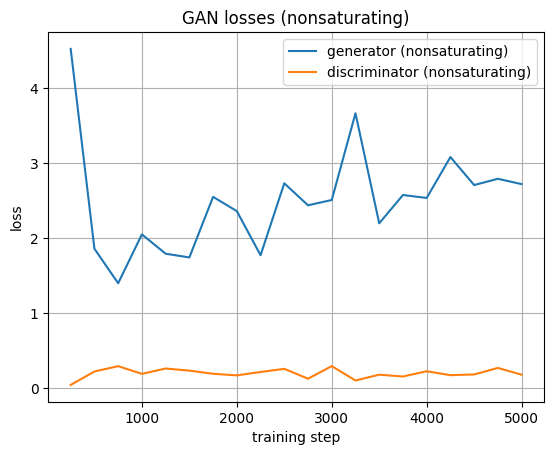

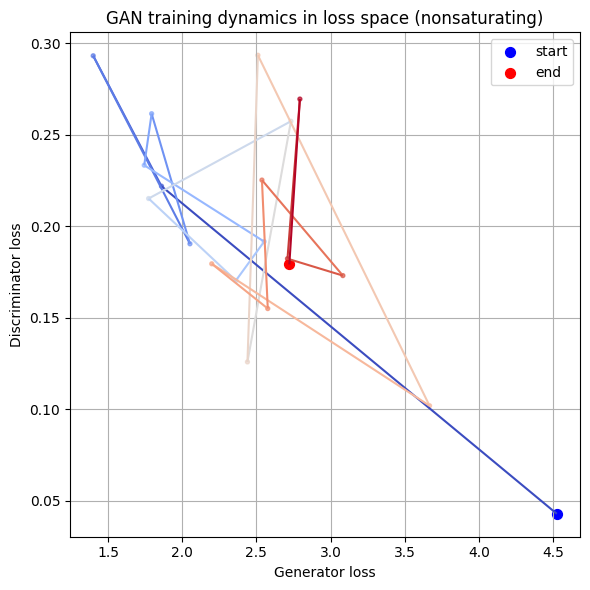

In [21]:
plot_experiment_for_loss_type(results_by_loss_type["saturating"], train_data)
plot_experiment_for_loss_type(results_by_loss_type["nonsaturating"], train_data)